## from https://web.stanford.edu/~boyd/papers/admm/

# Code

In [1]:
code = grabcode("https://web.stanford.edu/~boyd/papers/admm/lasso/lasso.html")


code =

    'function [z, history] = lasso(A, b, lambda, rho, alpha)
     % lasso  Solve lasso problem via ADMM
     %
     % [z, history] = lasso(A, b, lambda, rho, alpha);
     % 
     % Solves the following problem via ADMM:
     %
     %   minimize 1/2*|| Ax - b ||_2^2 + \lambda || x ||_1
     %
     % The solution is returned in the vector x.
     %
     % history is a structure that contains the objective value, the primal and 
     % dual residual norms, and the tolerances for the primal and dual residual 
     % norms at each iteration.
     % 
     % rho is the augmented Lagrangian parameter. 
     %
     % alpha is the over-relaxation parameter (typical values for alpha are 
     % between 1.0 and 1.8).
     %
     %
     % More information can be found in the paper linked at:
     % http://www.stanford.edu/~boyd/papers/distr_opt_stat_learning_admm.html
     %
     
     t_start = tic;
     
     %% Global constants and defaults
     
     QUIET    = 0;
     MAX_ITER = 1000;

In [2]:
%%file lasso.m

function [z, history] = lasso(A, b, lambda, rho, alpha)
% lasso  Solve lasso problem via ADMM
%
% [z, history] = lasso(A, b, lambda, rho, alpha);
%
% Solves the following problem via ADMM:
%
%   minimize 1/2*|| Ax - b ||_2^2 + \lambda || x ||_1
%
% The solution is returned in the vector x.
%
% history is a structure that contains the objective value, the primal and
% dual residual norms, and the tolerances for the primal and dual residual
% norms at each iteration.
%
% rho is the augmented Lagrangian parameter.
%
% alpha is the over-relaxation parameter (typical values for alpha are
% between 1.0 and 1.8).
%
%
% More information can be found in the paper linked at:
% http://www.stanford.edu/~boyd/papers/distr_opt_stat_learning_admm.html
%

t_start = tic;

%% Global constants and defaults

QUIET    = 0;
MAX_ITER = 1000;
ABSTOL   = 1e-4;
RELTOL   = 1e-2;

%% Data preprocessing

[m, n] = size(A);

% save a matrix-vector multiply
Atb = A'*b;

%% ADMM solver

x = zeros(n,1);
z = zeros(n,1);
u = zeros(n,1);

% cache the factorization
[L U] = factor(A, rho);

if ~QUIET
    fprintf('%3s\t%10s\t%10s\t%10s\t%10s\t%10s\n', 'iter', ...
      'r norm', 'eps pri', 's norm', 'eps dual', 'objective');
end

for k = 1:MAX_ITER

    % x-update
    q = Atb + rho*(z - u);    % temporary value
    if( m >= n )    % if skinny
       x = U \ (L \ q);
    else            % if fat
       x = q/rho - (A'*(U \ ( L \ (A*q) )))/rho^2;
    end

    % z-update with relaxation
    zold = z;
    x_hat = alpha*x + (1 - alpha)*zold;
    z = shrinkage(x_hat + u, lambda/rho);

    % u-update
    u = u + (x_hat - z);

    % diagnostics, reporting, termination checks
    history.objval(k)  = objective(A, b, lambda, x, z);

    history.r_norm(k)  = norm(x - z);
    history.s_norm(k)  = norm(-rho*(z - zold));

    history.eps_pri(k) = sqrt(n)*ABSTOL + RELTOL*max(norm(x), norm(-z));
    history.eps_dual(k)= sqrt(n)*ABSTOL + RELTOL*norm(rho*u);

    if ~QUIET
        fprintf('%3d\t%10.4f\t%10.4f\t%10.4f\t%10.4f\t%10.2f\n', k, ...
            history.r_norm(k), history.eps_pri(k), ...
            history.s_norm(k), history.eps_dual(k), history.objval(k));
    end

    if (history.r_norm(k) < history.eps_pri(k) && ...
       history.s_norm(k) < history.eps_dual(k))
         break;
    end

end

if ~QUIET
    toc(t_start);
end
end

function p = objective(A, b, lambda, x, z)
    p = ( 1/2*sum((A*x - b).^2) + lambda*norm(z,1) );
end

function z = shrinkage(x, kappa)
    z = max( 0, x - kappa ) - max( 0, -x - kappa );
end

function [L U] = factor(A, rho)
    [m, n] = size(A);
    if ( m >= n )    % if skinny
       L = chol( A'*A + rho*speye(n), 'lower' );
    else            % if fat
       L = chol( speye(m) + 1/rho*(A*A'), 'lower' );
    end

    % force matlab to recognize the upper / lower triangular structure
    L = sparse(L);
    U = sparse(L');
end

Created file '/home/wenh06/Jupyter/wenhao/workspace/fl_seminar/code/boyd-admm/lasso.m'.


# Example

In [3]:
eg_code = grabcode("https://web.stanford.edu/~boyd/papers/admm/lasso/lasso_example.html")


eg_code =

    '% L1-regularized least-squares example
     
     %% Generate problem data
     
     randn('seed', 0);
     rand('seed',0);
     
     m = 1500;       % number of examples
     n = 5000;       % number of features
     p = 100/n;      % sparsity density  
     
     x0 = sprandn(n,1,p);
     A = randn(m,n);
     A = A*spdiags(1./sqrt(sum(A.^2))',0,n,n); % normalize columns
     b = A*x0 + sqrt(0.001)*randn(m,1);
     
     lambda_max = norm( A'*b, 'inf' );
     lambda = 0.1*lambda_max; 
     
     %% Solve problem
     
     [x history] = lasso(A, b, lambda, 1.0, 1.0);
     
     %% Reporting
     K = length(history.objval);                                                                                                        
     
     h = figure;
     plot(1:K, history.objval, 'k', 'MarkerSize', 10, 'LineWidth', 2); 
     ylabel('f(x^k) + g(z^k)'); xlabel('iter (k)');
     
     g = figure;
     subplot(2,1,1);                                                       

### Generate problem data

In [4]:
randn('seed', 0);
rand('seed',0);

m = 1500;       % number of examples
n = 5000;       % number of features
p = 100/n;      % sparsity density

x0 = sprandn(n,1,p);
A = randn(m,n);
A = A*spdiags(1./sqrt(sum(A.^2))',0,n,n); % normalize columns
b = A*x0 + sqrt(0.001)*randn(m,1);

lambda_max = norm( A'*b, 'inf' );
lambda = 0.1*lambda_max;

### Solve problem

In [5]:
[x history] = lasso(A, b, lambda, 1.0, 1.0);

iter	    r norm	   eps pri	    s norm	  eps dual	 objective
  1	    3.7048	    0.0465	    0.7250	    0.0441	      3.35
  2	    2.2654	    0.0409	    1.7960	    0.0653	     10.13
  3	    1.0958	    0.0529	    2.0325	    0.0734	     15.14
  4	    0.8050	    0.0687	    1.7219	    0.0736	     17.68
  5	    0.8619	    0.0801	    1.2234	    0.0704	     18.69
  6	    0.8078	    0.0864	    0.7669	    0.0667	     18.92
  7	    0.6611	    0.0889	    0.4398	    0.0635	     18.80
  8	    0.4906	    0.0890	    0.2659	    0.0612	     18.49
  9	    0.3379	    0.0878	    0.2159	    0.0598	     18.12
 10	    0.2255	    0.0861	    0.1987	    0.0591	     17.78
 11	    0.1585	    0.0845	    0.1721	    0.0590	     17.51
 12	    0.1212	    0.0833	    0.1379	    0.0591	     17.35
 13	    0.0979	    0.0825	    0.1044	    0.0595	     17.27
 14	    0.0799	    0.0820	    0.0759	    0.0598	     17.25
 15	    0.0650	    0.0819	    0.0532	    0.0602	     17.27
 0.255388 


### Reporting

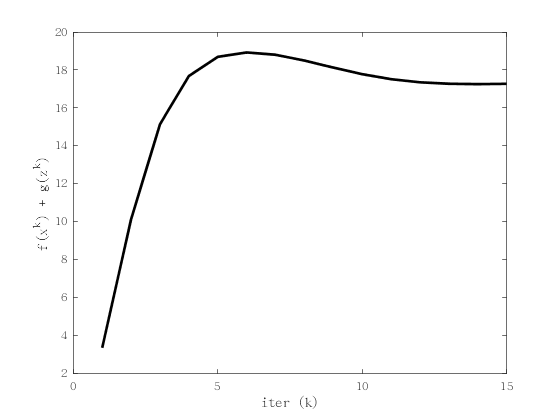

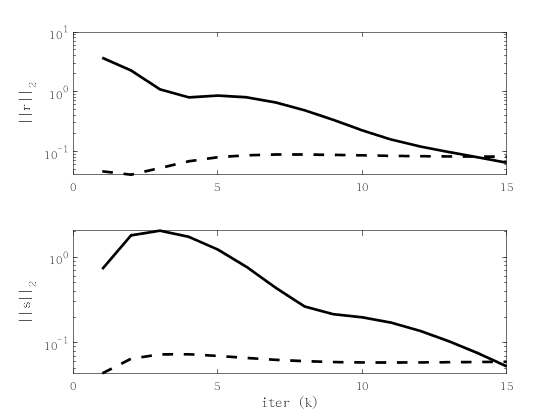

In [7]:
K = length(history.objval);

h = figure;
plot(1:K, history.objval, 'k', 'MarkerSize', 10, 'LineWidth', 2);
ylabel('f(x^k) + g(z^k)'); xlabel('iter (k)');

g = figure;
subplot(2,1,1);
semilogy(1:K, max(1e-8, history.r_norm), 'k', ...
    1:K, history.eps_pri, 'k--',  'LineWidth', 2);
ylabel('||r||_2');

subplot(2,1,2);
semilogy(1:K, max(1e-8, history.s_norm), 'k', ...
    1:K, history.eps_dual, 'k--', 'LineWidth', 2);
ylabel('||s||_2'); xlabel('iter (k)');